In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import multivariate_normal

#some functions of the following class have been generated by chatgpt
class PCAAnalyzer:
    def __init__(self, X):
        self.X = X
        self.mean = None
        self.std_dev = None
        self.X_scaled = None
        self.cov_matrix = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.explained_variances = None

    def standardize_features(self):
        self.mean = np.mean(self.X, axis=0)
        self.std_dev = np.std(self.X, axis=0)
        self.X_scaled = (self.X - self.mean) / self.std_dev

        if self.X_scaled.ndim > 2:
            self.X_scaled = self.X_scaled.reshape(self.X_scaled.shape[0], -1)

    def calculate_covariance_matrix(self):
        self.cov_matrix = np.cov(self.X_scaled, rowvar=False)

    def calculate_eigenvalues_and_eigenvectors(self):
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(self.cov_matrix)
        sorted_indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[:, sorted_indices]

    def calculate_cumulative_explained_variance(self):
        self.explained_variances = np.cumsum(self.eigenvalues) / np.sum(self.eigenvalues)

    def plot_cumulative_variance(self):
        fig = px.line(x=range(1, len(self.explained_variances) + 1), y=self.explained_variances, markers=True, title='Cumulative Explained Variance vs. Number of Principal Components')
        fig.update_layout(xaxis_title='Number of Principal Components', yaxis_title='Cumulative Explained Variance')
        fig.show()

#some functions of the below class generated by chatgpt
class GaussianMixtureModel:
    def __init__(self):
        self.weights = None
        self.means = None
        self.covariances = None
        self.num_components = None

    def fit(self, data, num_components, max_iterations=100, tolerance=1e-4):
        self.num_components = num_components
        num_samples, num_features = data.shape
        n, m= data.shape

        # Initialize parameters randomly
        self.weights = np.random.rand(num_components)
        self.weights /= np.sum(self.weights)
        self.means = np.random.rand(num_components, num_features)
        # self.covariances = [np.eye(num_features) for _ in range(num_components)]
        self.covariances = [np.cov(data.T) + 1e-6 * np.eye(m) for _ in range(num_components)]  # Add regularization term

        # # EM algorithm
        # for iteration in range(max_iterations):
        #     # E-step: Calculate responsibilities
        #     responsibilities = self.calculate_responsibilities(data)

        #     # M-step: Update parameters
        #     new_weights = np.mean(responsibilities, axis=0)
        #     new_means = np.dot(responsibilities.T, data) / np.sum(responsibilities, axis=0)[:, np.newaxis]
        #     new_covariances = []

        #     for i in range(num_components):
        #         diff = data - new_means[i]
        #         cov = np.dot(responsibilities[:, i] * diff.T, diff) / np.sum(responsibilities[:, i])
        #         new_covariances.append(cov)

        #     self.weights = new_weights / np.sum(new_weights)
        #     self.means = new_means
        #     self.covariances = new_covariances

        #     # Check for convergence
        #     if np.max(np.abs(new_weights - self.weights)) < tolerance:
        #         break

        # EM algorithm
        for iteration in range(max_iterations):
            # E-step: Calculate responsibilities
            responsibilities = self.calculate_responsibilities(data)

            # M-step: Update parameters
            new_weights = np.mean(responsibilities, axis=0)
            new_means = np.dot(responsibilities.T, data) / np.sum(responsibilities, axis=0)[:, np.newaxis]
            new_covariances = []

            for i in range(num_components):
                diff = data - new_means[i]
                cov = np.dot(responsibilities[:, i] * diff.T, diff) / np.sum(responsibilities[:, i])

                # Add regularization as identity matrix times 1e-6
                cov_regularized = cov + 1e-6 * np.eye(num_features)

                new_covariances.append(cov_regularized)

            self.weights = new_weights / np.sum(new_weights)
            self.means = new_means
            self.covariances = new_covariances

            # Check for convergence
            if np.max(np.abs(new_weights - self.weights)) < tolerance:
                break


    def calculate_responsibilities(self, data):
        num_samples = data.shape[0]
        responsibilities = np.zeros((num_samples, self.num_components))

        for i in range(self.num_components):
            mvn = multivariate_normal(self.means[i], self.covariances[i])
            responsibilities[:, i] = self.weights[i] * mvn.pdf(data)

        normalization = np.sum(responsibilities, axis=1)[:, np.newaxis]
        responsibilities /= normalization

        return responsibilities

    def likelihood(self, data):
        responsibilities = self.calculate_responsibilities(data)
        likelihoods = np.sum(np.log(np.maximum(np.sum(responsibilities, axis=1), 1e-10)))
        return likelihoods
    
    def plot_clusters(self, data):
        cluster_labels = self.predict(data)
        df = pd.DataFrame(data, columns=['Feature1', 'Feature2'])
        df['Cluster'] = cluster_labels

        fig = px.scatter(df, x='Feature1', y='Feature2', color='Cluster', title='GMM Clustering')
        fig.show()

    def predict(self, data):
        responsibilities = self.calculate_responsibilities(data)
        return np.argmax(responsibilities, axis=1)
    
    def get_parameters(self):
        return self.weights, self.means, self.covariances
    
    def get_membership_values(self, data):
        responsibilities = self.calculate_responsibilities(data)
        return responsibilities

        



In [47]:
data=pd.read_csv('data.csv')
data = data.drop(columns=['Index'])
# print(data.head())
data_array = data.to_numpy()

analyzer = PCAAnalyzer(data_array)

analyzer.standardize_features()
analyzer.calculate_covariance_matrix()
analyzer.calculate_eigenvalues_and_eigenvectors()

X=data_array
mean = np.mean(X, axis=0)
std_dev = np.std(X, axis=0)
X_scaled = (X - mean) / std_dev


num_components = 3  

top_eigenvectors = analyzer.eigenvectors[:, :num_components]

X_scaled = np.dot(X_scaled, top_eigenvectors)

# print(X_scaled.shape)



g=GaussianMixtureModel()

g.fit(X_scaled,3)

# print(g.weights)

# print(g.likelihood(X_scaled))

weights, means, covariances = g.get_parameters()
print("GMM Parameters:")
print("Weights:", weights)
print("Means:", means)
print("Covariances:", covariances)

likelihood = g.likelihood(X_scaled)
print("Likelihood:", likelihood)

membership_values = g.get_membership_values(X_scaled)
print("Membership values:")
print(membership_values)

GMM Parameters:
Weights: [0.05278199 0.76313332 0.1840847 ]
Means: [[-0.38116563 -0.39672352  0.17157362]
 [ 0.03904128  0.00437994  0.02993068]
 [-0.05255747  0.09559391 -0.17327404]]
Covariances: [array([[ 2.26992171, -0.15497529,  0.11812459],
       [-0.15497529,  1.87246759, -0.12292181],
       [ 0.11812459, -0.12292181,  1.4188354 ]]), array([[ 2.52552452, -0.02372501,  0.00928939],
       [-0.02372501,  1.84453909, -0.00853396],
       [ 0.00928939, -0.00853396,  1.32738334]]), array([[ 2.40259425,  0.10374615, -0.06757887],
       [ 0.10374615,  1.7443039 ,  0.10616017],
       [-0.06757887,  0.10616017,  1.20518023]])]
Likelihood: -2.4313884239290928e-14
Membership values:
[[0.06355002 0.86373243 0.07271755]
 [0.04143072 0.72301585 0.23555343]
 [0.06322367 0.80030133 0.136475  ]
 ...
 [0.04172481 0.76594169 0.1923335 ]
 [0.07016937 0.71878028 0.21105035]
 [0.04305641 0.76652787 0.19041573]]


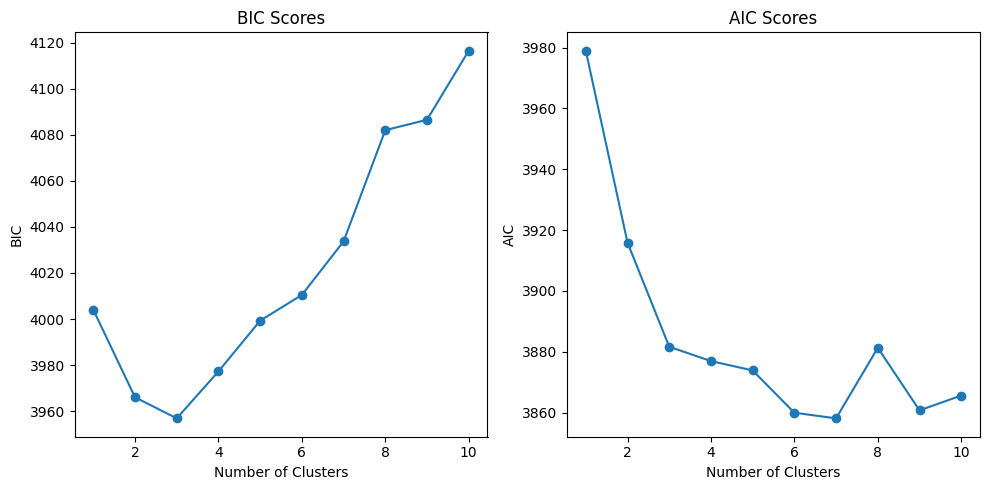

/home/yash/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


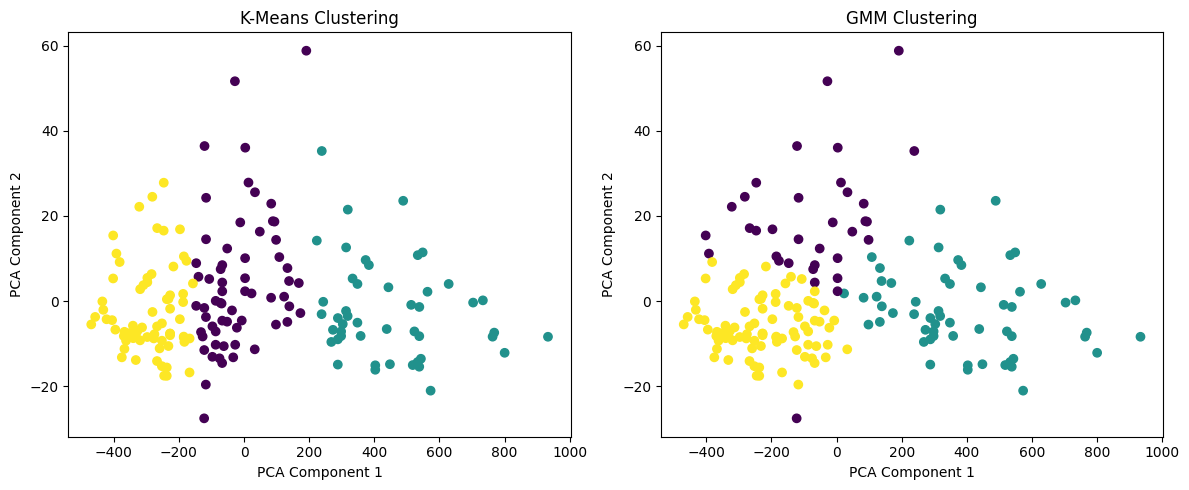

K-Means Silhouette Score: 0.5722554756855063
GMM Silhouette Score: 0.2623333079949891


/home/yash/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yash/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yash/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yash/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yash/.local/lib/python3.10/site-pa

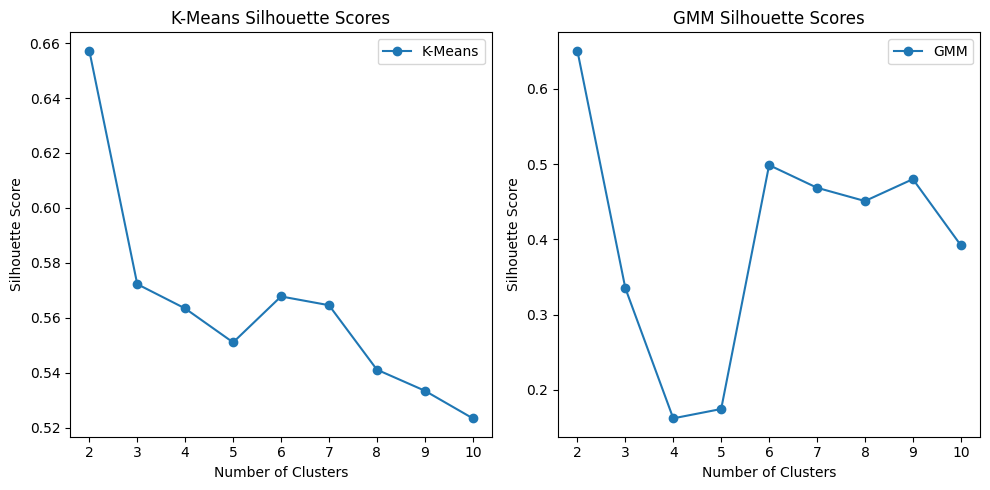

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import multivariate_normal

wine = datasets.load_wine()
X = wine.data

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Find the optimal number of clusters for GMM using BIC and AIC
n_components_range = range(1, 11)
bic_scores = []
aic_scores = []

#code to calculate aic and bic generated by chatgpt
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X_pca)
    
    # Calculate the BIC and AIC scores manually
    log_likelihood = gmm.score_samples(X_pca)
    n_params = n_components * (X_pca.shape[1] * 2 + 2)  # Number of parameters in GMM
    bic = -2 * np.sum(log_likelihood) + n_params * np.log(X_pca.shape[0])
    aic = -2 * np.sum(log_likelihood) + n_params
    
    bic_scores.append(bic)
    aic_scores.append(aic)

#plotting code generated by chatgpt
# Plot BIC and AIC scores to determine the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, marker='o', linestyle='-')
plt.title('BIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic_scores, marker='o', linestyle='-')
plt.title('AIC Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC')

plt.tight_layout()
plt.show()

# Based on the BIC and AIC scores, choose the optimal number of clusters for GMM
optimal_n_components = np.argmin(bic_scores) + 1  # Add 1 since the range starts from 1

kmeans = KMeans(n_clusters=optimal_n_components, random_state=0)
kmeans_labels = kmeans.fit_predict(X_pca)

gmm = GaussianMixture(n_components=optimal_n_components)
gmm_labels = gmm.fit_predict(X_pca)

#silhoutte score code generated by chatgpt
# Compute Silhouette scores for both K-Means and GMM
kmeans_silhouette_score = silhouette_score(X_pca, kmeans_labels)
gmm_silhouette_score = silhouette_score(X_pca, gmm_labels)

# Plot scatter plots for K-Means and GMM clustering
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title('GMM Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

# Print Silhouette scores
print(f"K-Means Silhouette Score: {kmeans_silhouette_score}")
print(f"GMM Silhouette Score: {gmm_silhouette_score}")

# Initialize lists to store silhouette scores
kmeans_silhouette_scores = []
gmm_silhouette_scores = []
n_components_range = range(2, 11)


# Calculate Silhouette scores for different numbers of clusters starting from 2
for n_clusters in n_components_range:
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_labels = kmeans.fit_predict(X_pca)

    # Perform GMM clustering
    gmm = GaussianMixture(n_components=n_clusters)
    gmm_labels = gmm.fit_predict(X_pca)

    # Compute Silhouette scores for both K-Means and GMM
    kmeans_silhouette_score = silhouette_score(X_pca, kmeans_labels)
    gmm_silhouette_score = silhouette_score(X_pca, gmm_labels)

    kmeans_silhouette_scores.append(kmeans_silhouette_score)
    gmm_silhouette_scores.append(gmm_silhouette_score)

#plotting code generated by chatgpt
# Plot Silhouette scores vs. Number of Clusters
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, kmeans_silhouette_scores, marker='o', linestyle='-', label='K-Means')
plt.title('K-Means Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_components_range, gmm_silhouette_scores, marker='o', linestyle='-', label='GMM')
plt.title('GMM Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()

plt.tight_layout()
plt.show()


<h3> Observations </h3>

1. The silhouette score measures how close each data point in one cluster is to the data points in the neighboring clusters. A higher silhouette score indicates that the clusters are well-separated.
2. For the K means clustering silhouette score is maximised at 3 clusters and we can see from the cluster graphs that 3 clusters fit the graphs